---
# Phoenix Temperatures Time Series Mini Project 
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from datetime import datetime

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 7))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

---
## Acquire and Prepare
---

In [2]:
def C_to_F(temp):
    '''
    Converts temp from C to F
    '''
    return (temp * (9/5) + 32)

In [3]:
def get_data():
    '''
    Gets data from csv, filters to Phoenix, sets datetime index, only pulls temperature column, converts from C to F and selects data from 2008 to 2012
    '''
    df = pd.read_csv('GlobalLandTemperaturesByCity.csv')
    df = df[df.City == 'Phoenix']
    df = df.rename(columns={'AverageTemperature' : 'avg_temp', 'dt' : 'Date'})
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index('Date')
    df = df.sort_index()
    df = df[['avg_temp']]    
    df = df.apply(C_to_F)
    df = df['2008': '2012']
    return df

In [4]:
# see function above for details of acquisition and preparation
df = get_data()

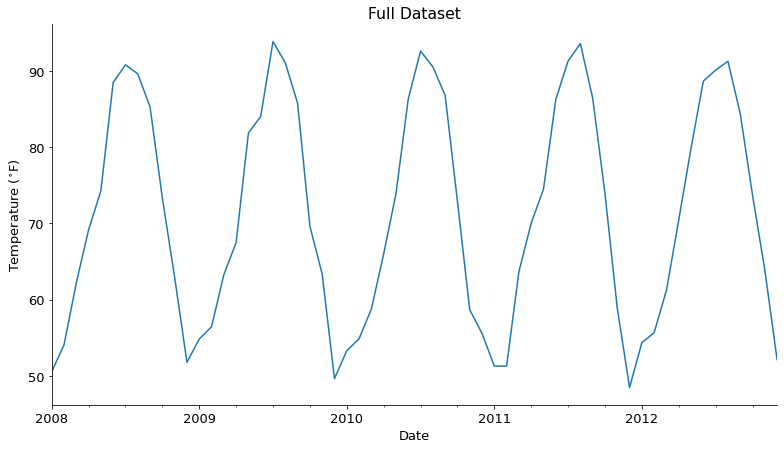

In [5]:
df.avg_temp.plot()
plt.title('Full Dataset')
plt.ylabel('Temperature ($^{\circ}$F)');

---
### Split

In [6]:
train = df[:'2010']
validate = df['2011']
test = df['2012']

In [7]:
# create a function to visualize splits
def viz_splits(train, validate, test):
    ax = train.avg_temp.plot(label='train')
    validate.avg_temp.plot(ax=ax, label='validate')
    test.avg_temp.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Temperature ($^{\circ}$F)')
    plt.show();

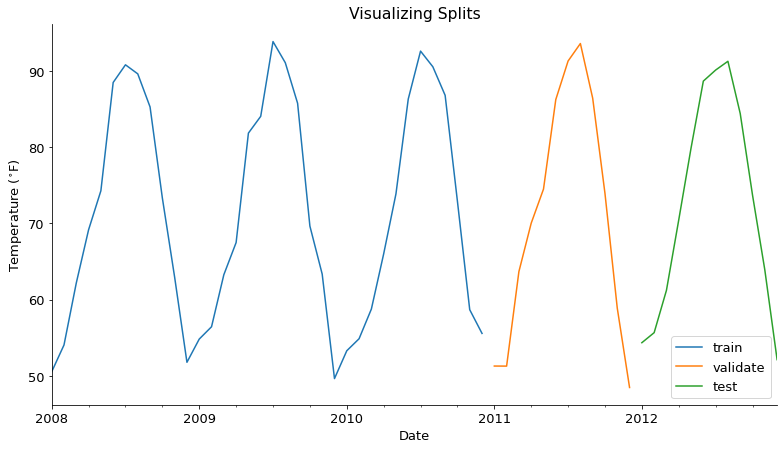

In [8]:
# make sure splits worked properly
viz_splits(train, validate, test)

In [9]:
# let's see how many data points we have for each split
train.shape, validate.shape, test.shape

((36, 1), (12, 1), (12, 1))

---
## Explore
---

### Seasonal Decomposition 

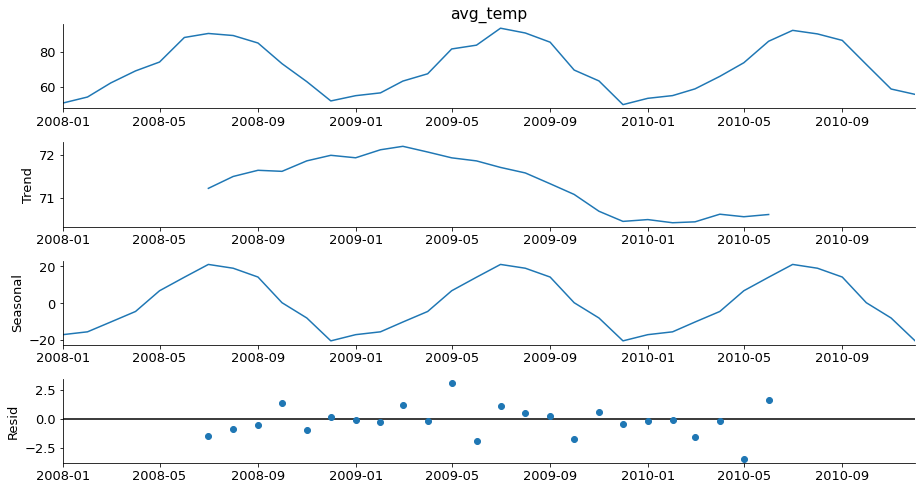

In [10]:
# let's take a look at the seasonal decomposition for this data
_ = sm.tsa.seasonal_decompose(train.avg_temp).plot()

- Trend is interesting here. It increases and then decreases. Due to this fluctuation, I will try 2 training sets and see which performs better.

---
### Average Temperature By Month

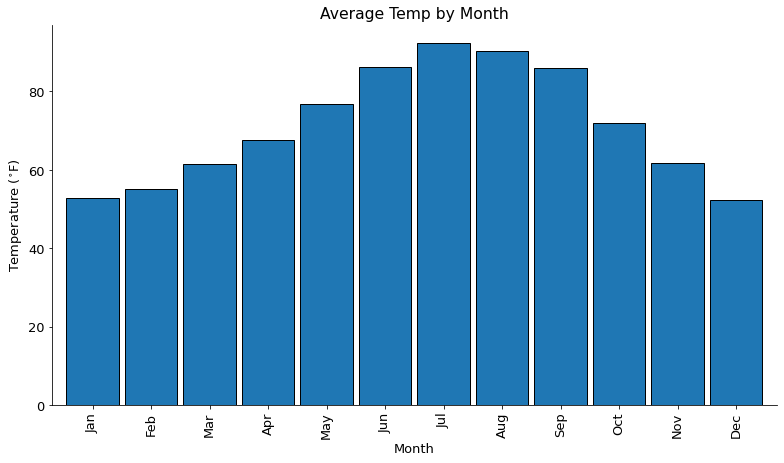

In [11]:
# Let's take a look at the average temperature by month
ax = train.avg_temp.groupby(train.index.strftime('%m-%b')).mean().plot.bar(width=.9, ec='black')
labels = ax.get_xticklabels()
ax.set_xticklabels([l.get_text()[3:] for l in labels])
plt.title('Average Temp by Month')
plt.ylabel('Temperature ($^{\circ}$F)')
plt.xlabel('Month');

- Trend is as-expected

---
### Average Temperature By Year

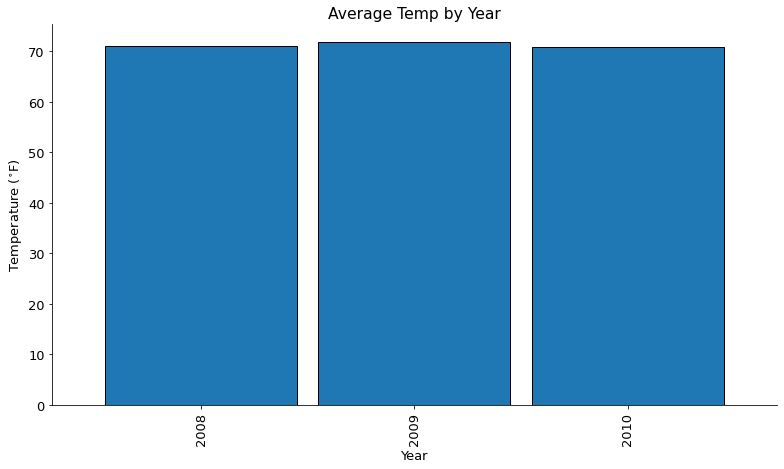

In [12]:
# Let's take a look at the average temperature by month
ax = train.avg_temp.groupby(train.index.strftime('%Y')).mean().plot.bar(width=.9, ec='black')
plt.title('Average Temp by Year')
plt.ylabel('Temperature ($^{\circ}$F)')
plt.xlabel('Year');

- Not much variation for years in training set

---
### Rolling Averages

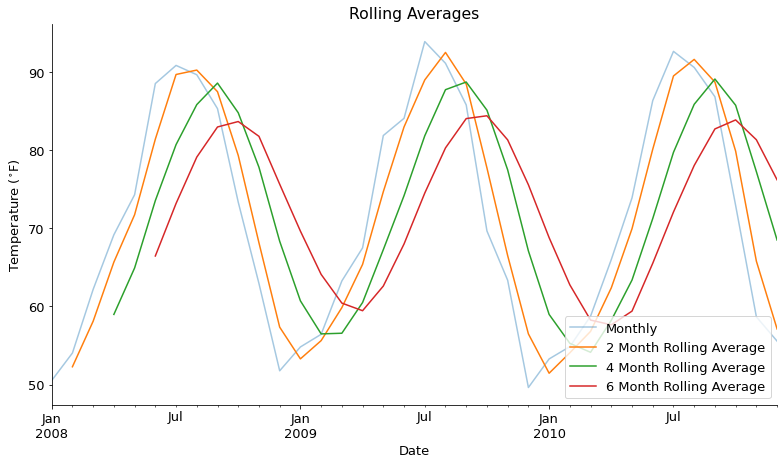

In [13]:
# moving averages
ax = train.avg_temp.plot(label='Monthly', alpha=.4)
train.avg_temp.rolling(2).mean().plot(ax=ax, label='2 Month Rolling Average')
train.avg_temp.rolling(4).mean().plot(ax=ax, label='4 Month Rolling Average')
train.avg_temp.rolling(6).mean().plot(ax=ax, label='6 Month Rolling Average')
plt.title('Rolling Averages')
plt.ylabel('Temperature ($^{\circ}$F)')
ax.legend(loc = 'lower right');

- Increasing period of rolling average smoothes curve and reduces overall magnitude

---
### Change in Temperature from Month to Month

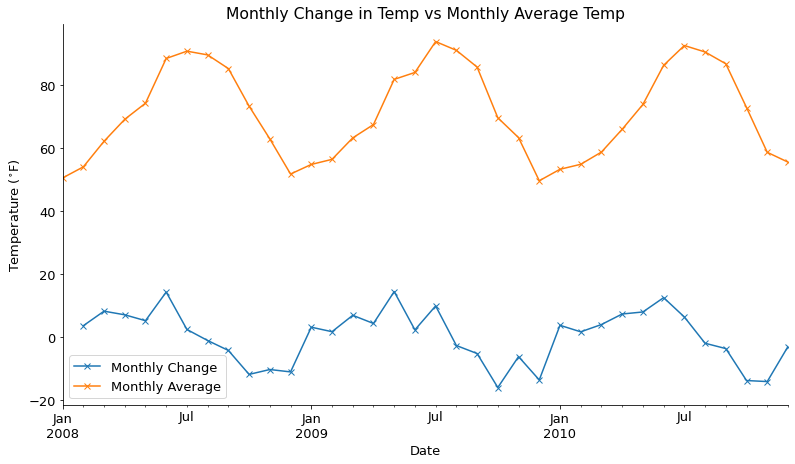

In [14]:
# monthly change in temperature
ax = train.avg_temp.diff().plot(label='Monthly Change', marker='x')
train.avg_temp.plot(ax=ax, label='Monthly Average', marker='x')
plt.title('Monthly Change in Temp vs Monthly Average Temp')
plt.ylabel('Temperature ($^{\circ}$F)')
plt.legend();

- Change in average temperature from one month to the next never exceeds 20$^{\circ}$F

---
### Year Over Year Change in Monthly Temperature

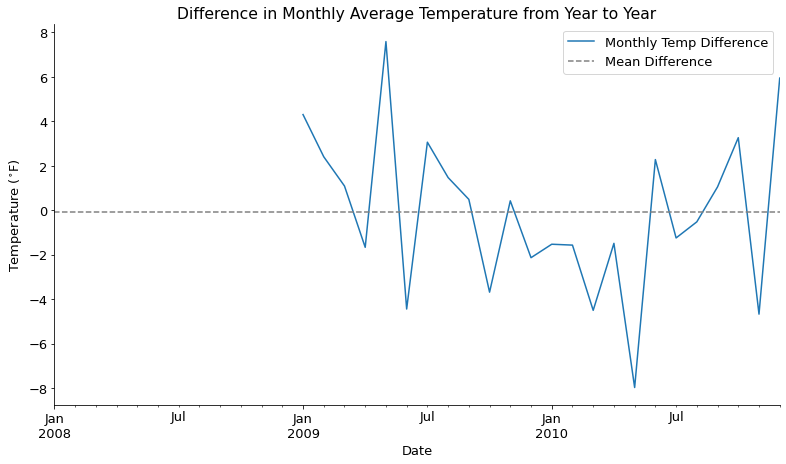

In [15]:
# difference in monthly average temperature from year to year
train.avg_temp.diff(12).plot(label = 'Monthly Temp Difference')
plt.axhline(train.avg_temp.diff(12).mean(), label='Mean Difference', ls='--', color='gray')
plt.title('Difference in Monthly Average Temperature from Year to Year')
plt.ylabel('Temperature ($^{\circ}$F)')
plt.legend();

- Year-over-year change in average monthly temperature never exceeds 8$^{\circ}$F

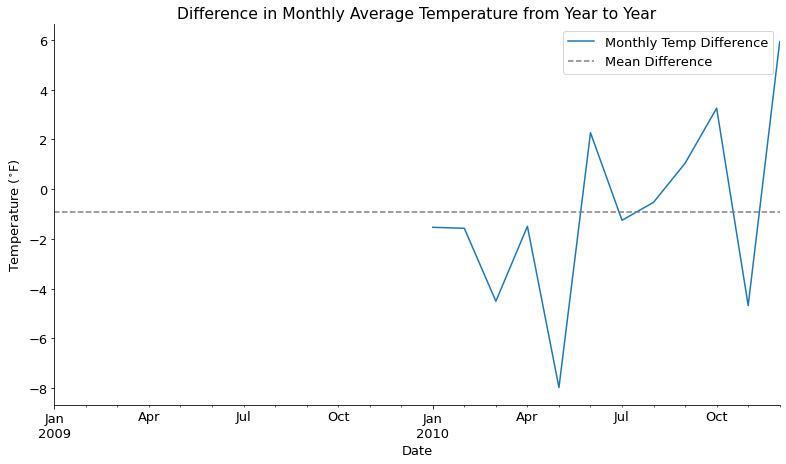

In [16]:
# change splits and take a look at how the mean difference changes
train = df['2009' : '2010']
validate = df['2011']
test = df['2012']

# difference in monthly average temperature from year to year
train.avg_temp.diff(12).plot(label = 'Monthly Temp Difference')
plt.axhline(train.avg_temp.diff(12).mean(), label='Mean Difference', ls='--', color='gray')
plt.title('Difference in Monthly Average Temperature from Year to Year')
plt.ylabel('Temperature ($^{\circ}$F)')
plt.legend();

- Average year-over-year change in average monthly temperature decreases with a smaller train set

In [17]:
# change splits back
train = df[:'2010']
validate = df['2011']
test = df['2012']

---
### Overlay from Previous Year

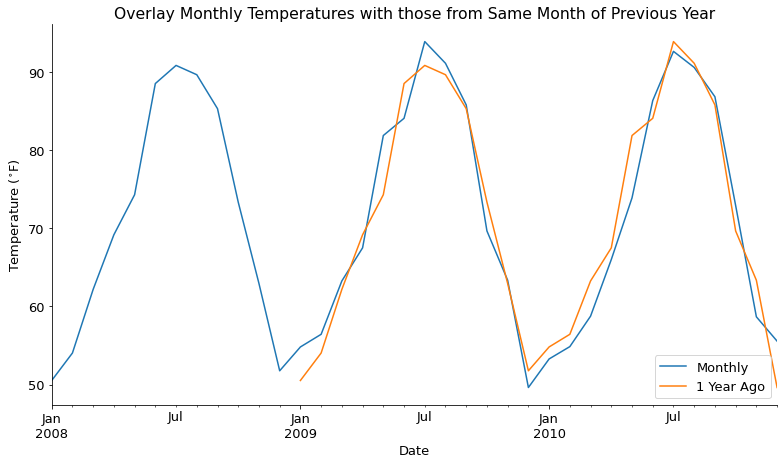

In [18]:
# use shift to overlay daily sales average for same month previous year
ax = train.avg_temp.plot(label='Monthly')
train.avg_temp.shift(12).plot(label='1 Year Ago', ax=ax)
plt.title('Overlay Monthly Temperatures with those from Same Month of Previous Year')
plt.ylabel('Temperature ($^{\circ}$F)')
ax.legend();

- Previous year tends to be a pretty good predictor of the next year

---
### Lag Plots

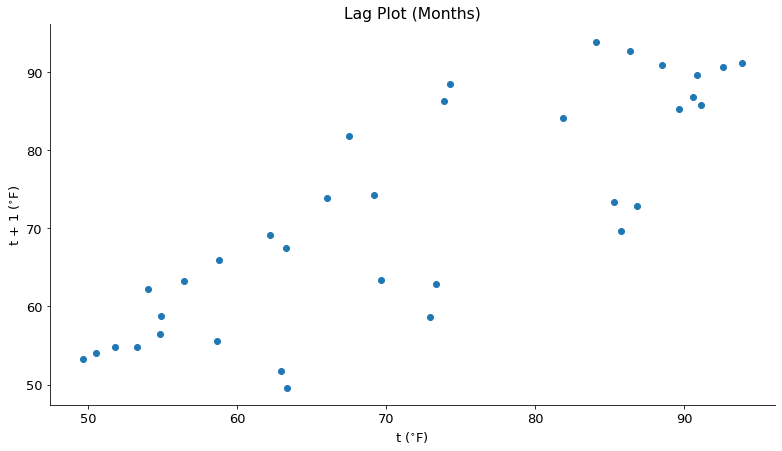

In [19]:
# Lag plot for lag period of 1 month
pd.plotting.lag_plot(train.avg_temp, 1)
plt.title('Lag Plot (Months)')
plt.xlabel('t ($^{\circ}$F)')
plt.ylabel('t + 1 ($^{\circ}$F)');

- Next month's average temperature is a decently positively correlated to this month's average temperature

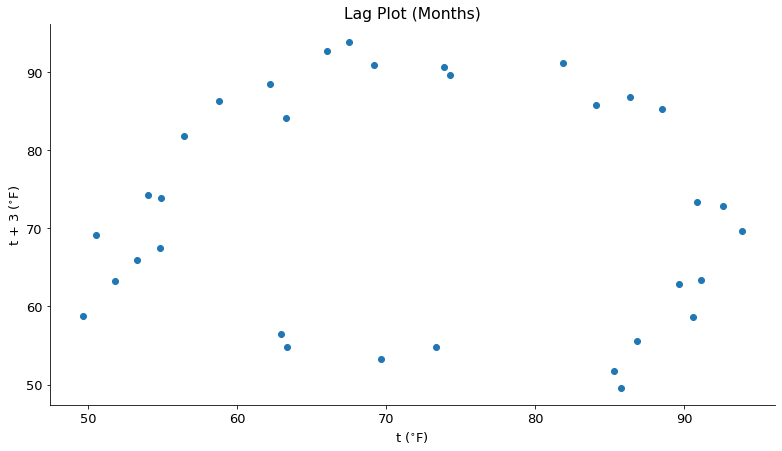

In [20]:
# Lag plot for lag period of 3 month
pd.plotting.lag_plot(train.avg_temp, 3)
plt.title('Lag Plot (Months)')
plt.xlabel('t ($^{\circ}$F)')
plt.ylabel('t + 3 ($^{\circ}$F)');

- The average temperature for 3 months ahead is not very correlated with this month's temperature 

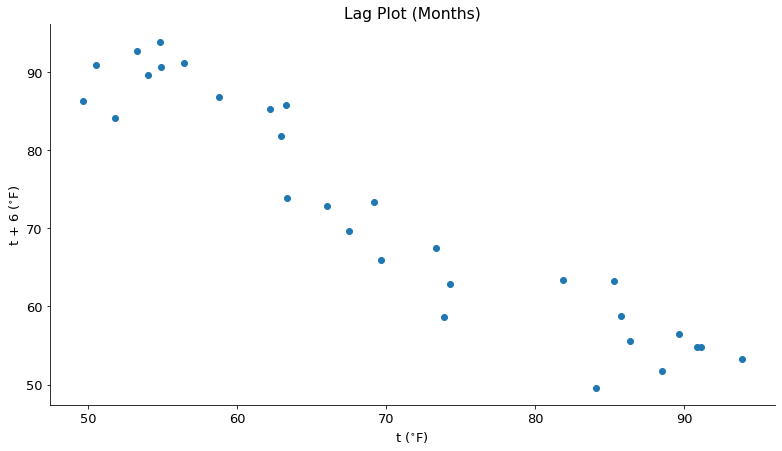

In [21]:
# Lag plot for lag period of 3 month
pd.plotting.lag_plot(train.avg_temp, 6)
plt.title('Lag Plot (Months)')
plt.xlabel('t ($^{\circ}$F)')
plt.ylabel('t + 6 ($^{\circ}$F)');

- The average temperature for 6 months ahead is highly negatively correlated with this month's temperature

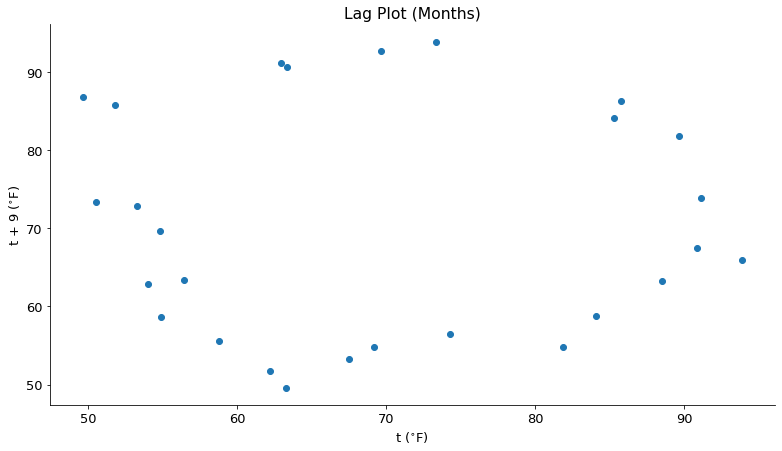

In [22]:
# Lag plot for lag period of 3 month
pd.plotting.lag_plot(train.avg_temp, 9)
plt.title('Lag Plot (Months)')
plt.xlabel('t ($^{\circ}$F)')
plt.ylabel('t + 9 ($^{\circ}$F)');

- The average temperature for 9 months ahead is not very correlated with this month's temperature 

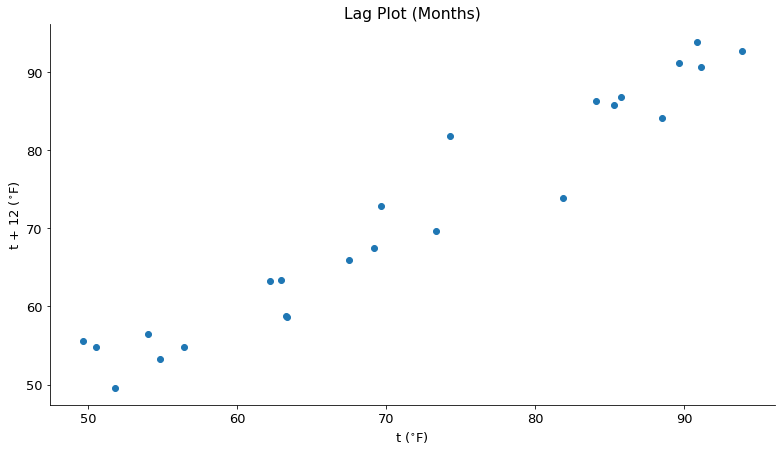

In [23]:
# Lag plot for lag period of 3 month
pd.plotting.lag_plot(train.avg_temp, 12)
plt.title('Lag Plot (Months)')
plt.xlabel('t ($^{\circ}$F)')
plt.ylabel('t + 12 ($^{\circ}$F)');

- The average temperature for 12 months ahead is highly positively correlated with this month's temperature

---
### Autocorrelation Plots

In [24]:
def autocorrelation(s, lag):
    return pd.concat([s, s.shift(lag)], axis=1).dropna().corr().iloc[0, 1]

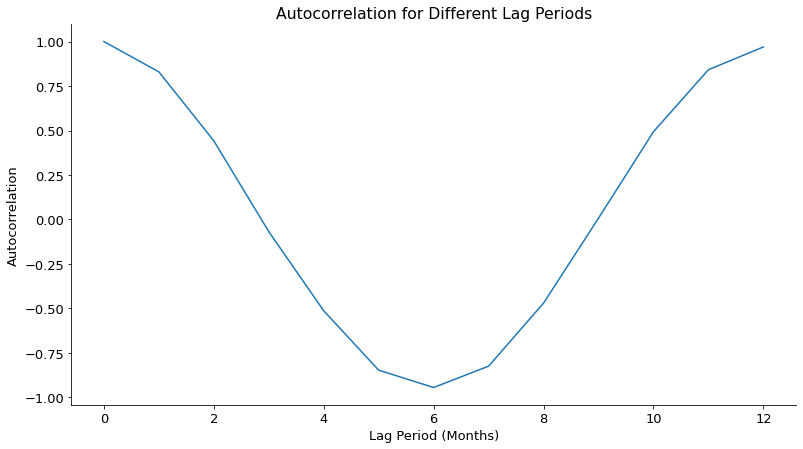

In [25]:
autocorr = pd.Series({lag: autocorrelation(train.avg_temp, lag) for lag in range(0, 13)})
autocorr.plot(xlabel='Lag Period (Months)', ylabel='Autocorrelation', title='Autocorrelation for Different Lag Periods');

- Autocorrelation is highest at 6 and 12 months but with opposite polarity

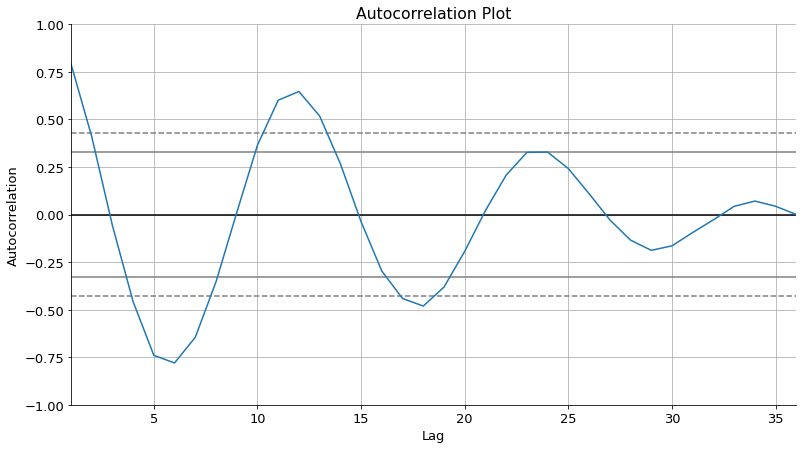

In [26]:
pd.plotting.autocorrelation_plot(train.avg_temp)
plt.title('Autocorrelation Plot');

- As lag increases, magnitude of autocorrelation decreases, but trend remains the same

---
### Seasonal Plot

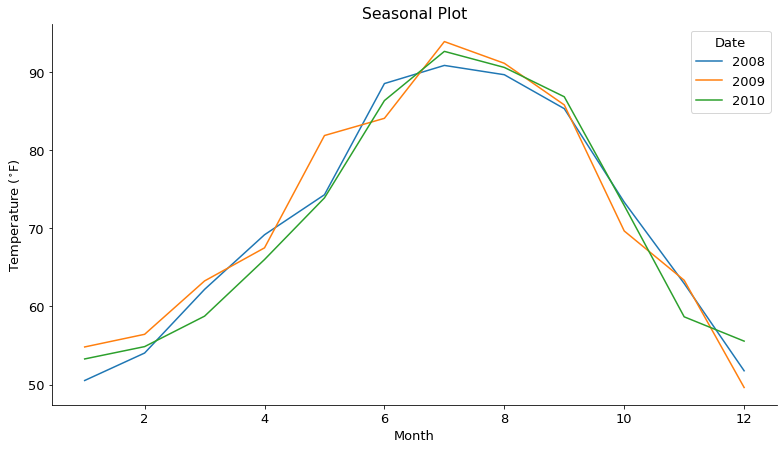

In [27]:
# show each year as a separate line using seasonal plot
train.avg_temp.groupby([train.index.year, train.index.month]).mean().unstack(0).plot(ylabel='Temperature ($^{\circ}$F)', xlabel='Month', title='Seasonal Plot');

- There is a very strong seasonal trend that temperatures follow each year

---
### Seasonal Subseries Plot

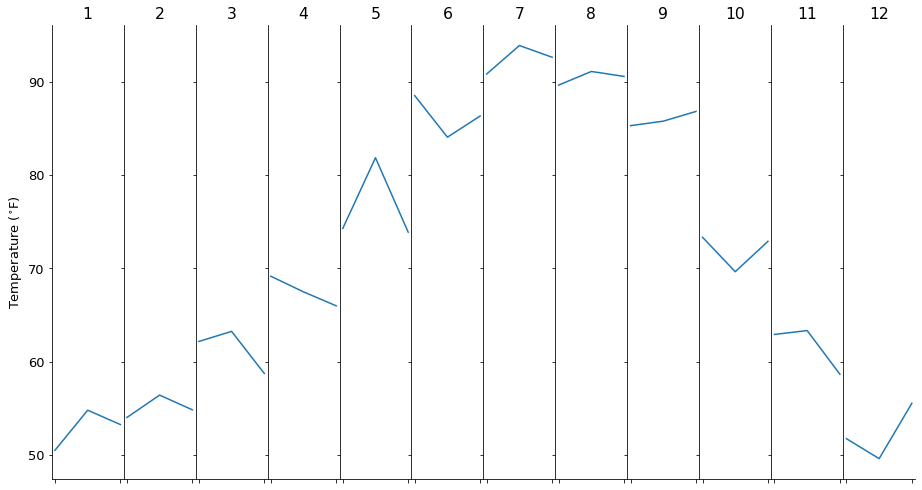

In [28]:
# let's look at year over year trend within each month
fig, axs = plt.subplots(1, 12, sharex=True, sharey=True)
for ax, (month, x) in zip(axs, train.avg_temp.groupby([train.index.year, train.index.month]).mean().unstack().iteritems()):
    x.plot(ax=ax, title=month, xlabel='', ylabel='Temperature ($^{\circ}$F)')
    labels = ax.get_xticklabels()
    ax.set_xticklabels([l.get_text() for l in labels])
fig.tight_layout()
fig.subplots_adjust(wspace=0)

- Interesting to see year-over-year trend within each month

---
## Forecast and Evaluate
---

### Define Plotting and Evaluation Functions

In [29]:
# define evaluation function to compute rmse
def evaluate(target_var):
    '''
    Will take target and compues rmse using actual values and predicted values for validate
    '''
    rmse = round(mean_squared_error(validate[target_var], yhat_df[target_var], squared=False),2)
    return rmse

In [30]:
# plot actual vs predicted
def plot_act_vs_pred(target_var):
    '''
    a function to plot splits along with predictions
    '''
    plt.plot(train[target_var], label='Train')
    plt.plot(validate[target_var], label='Validate')
    plt.plot(test[target_var], label='Test')
    plt.xlabel('Date')
    plt.ylabel('Temperature ($^{\circ}$F)')
    plt.plot(yhat_df[target_var], label = 'Prediction')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()

In [31]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [32]:
# Define function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    Store evaluation metric (rmse) for each model into a df for easy comparison
    '''
    rmse = evaluate(target_var)
    d = {'model_type' : [model_type],
        'target_var' : [target_var],
         'rmse' : [rmse]
        }
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

In [33]:
def make_predictions():
    '''
    Makes predictions and stores them in a df
    '''
    yhat_df = pd.DataFrame({'avg_temp' : [temp]}, index = validate.index)
    return yhat_df

In [34]:
# define target for rest of notebook since there is only one in this case
target = 'avg_temp'

---
### Last Observed Value

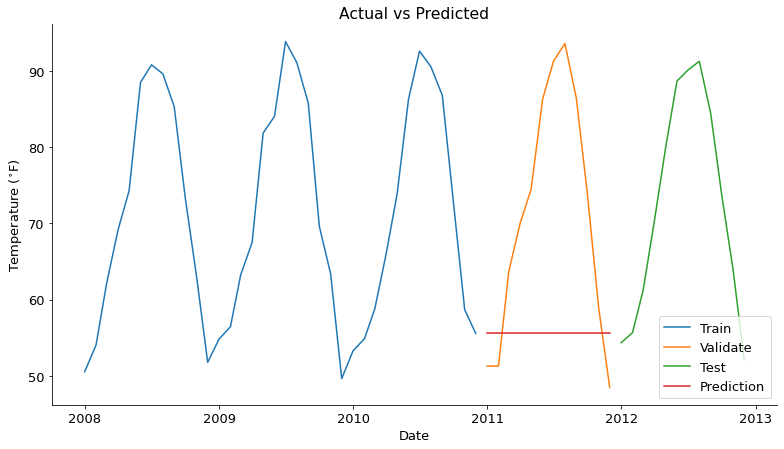

In [35]:
# Get prediction value
temp = train.avg_temp[-1]

# Make prediction
yhat_df = make_predictions()

# Plot prediction
plot_act_vs_pred(target)

# Evaluate forecast
eval_df = append_eval_df(model_type='Last Observed Value', target_var=target)

---
### Simple Average

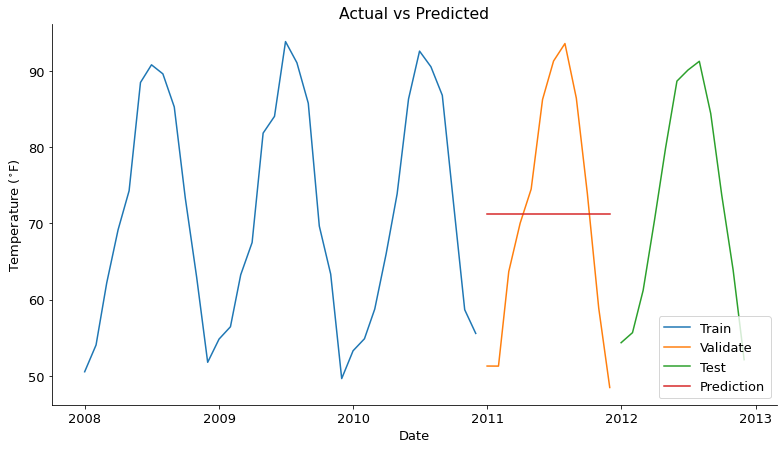

In [36]:
# Get prediction value
temp = train.avg_temp.mean()

# Make prediction
yhat_df = make_predictions()

# Plot prediction
plot_act_vs_pred(target)

# Evaluate forecast
eval_df = append_eval_df(model_type='Simple Average', target_var=target)

---
### Moving Average

1M Moving Average


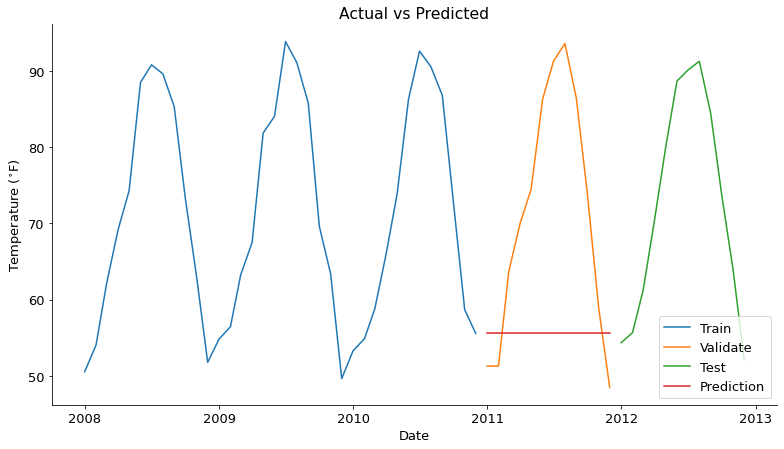

2M Moving Average


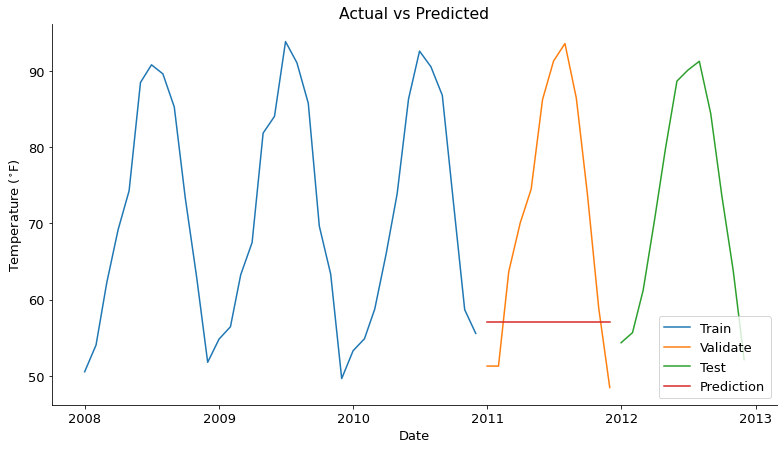

3M Moving Average


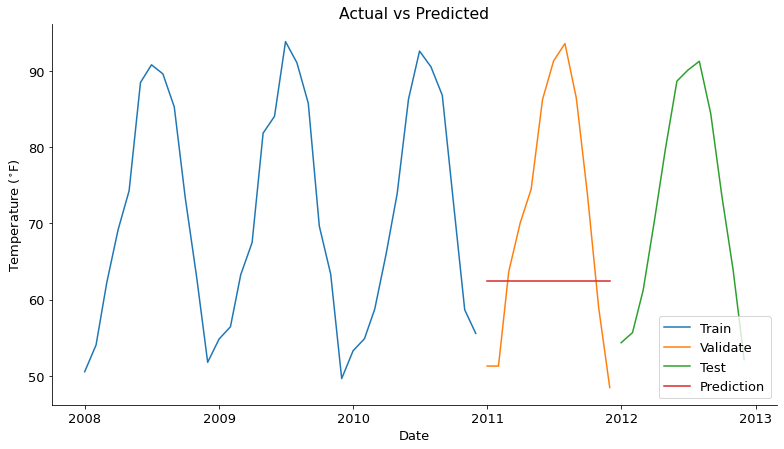

4M Moving Average


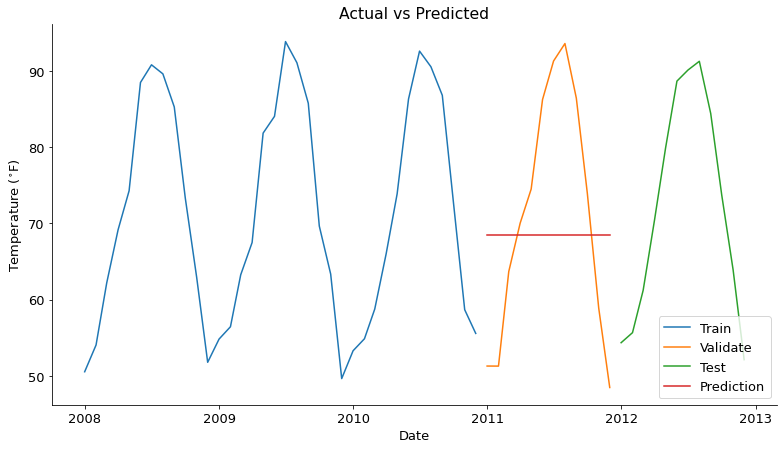

5M Moving Average


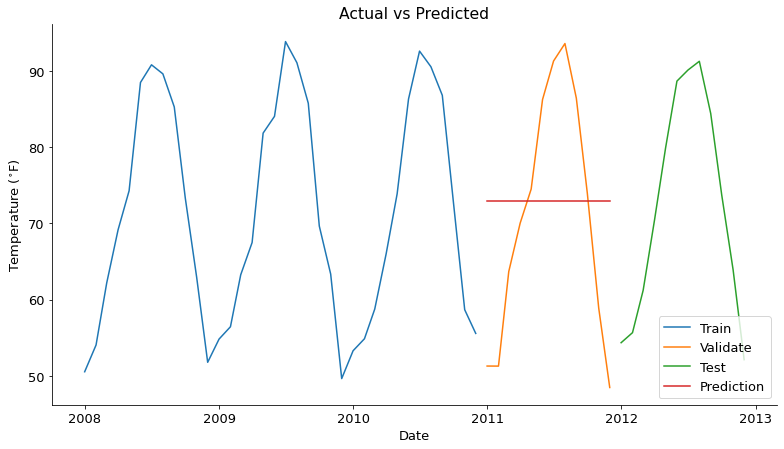

6M Moving Average


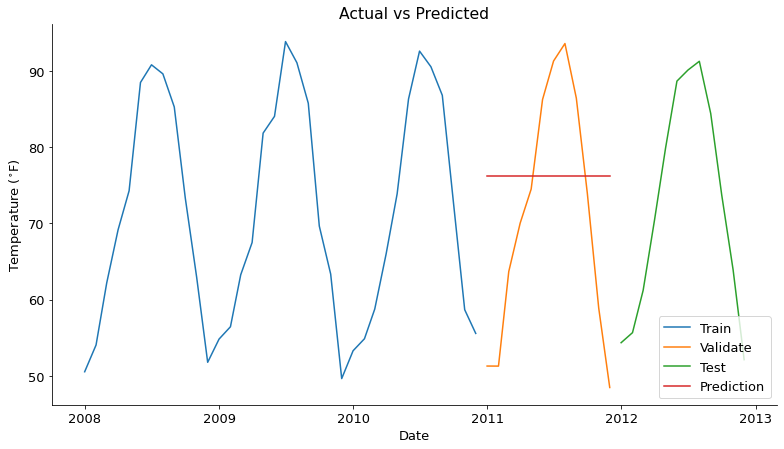

7M Moving Average


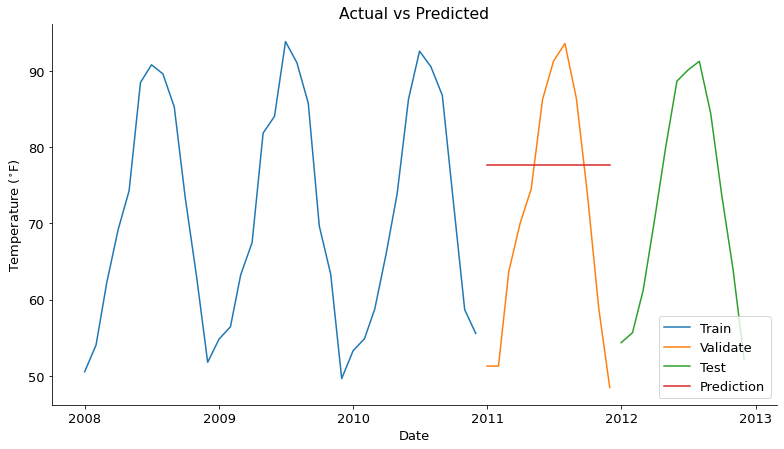

8M Moving Average


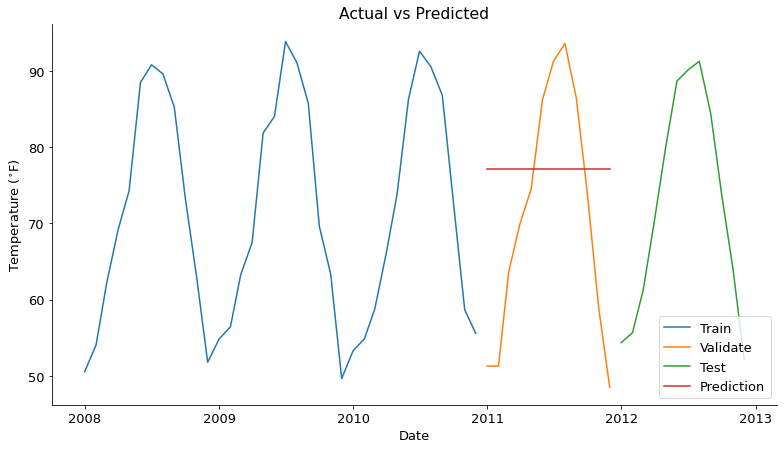

9M Moving Average


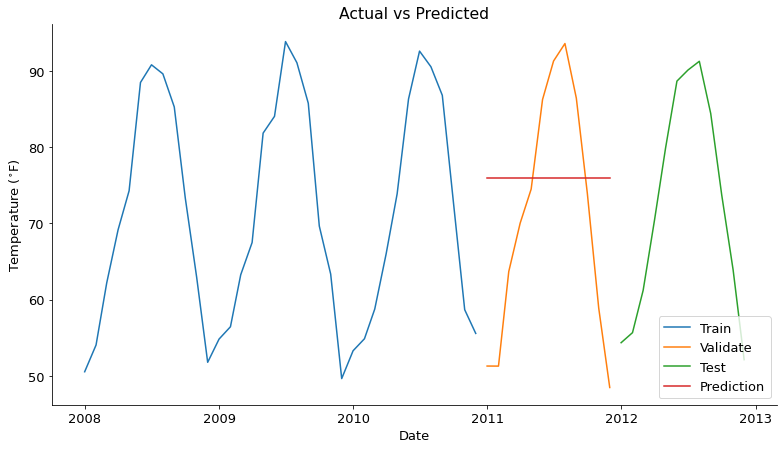

10M Moving Average


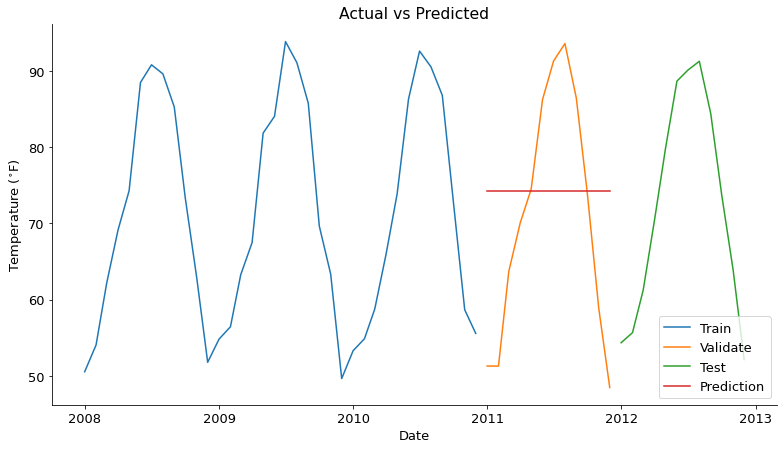

11M Moving Average


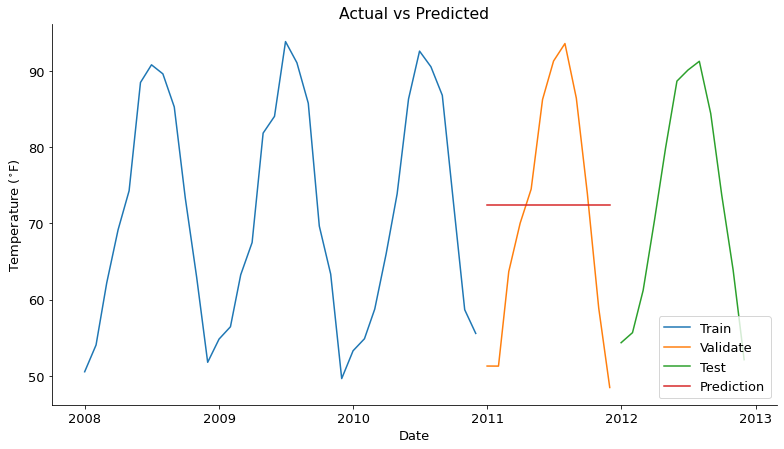

12M Moving Average


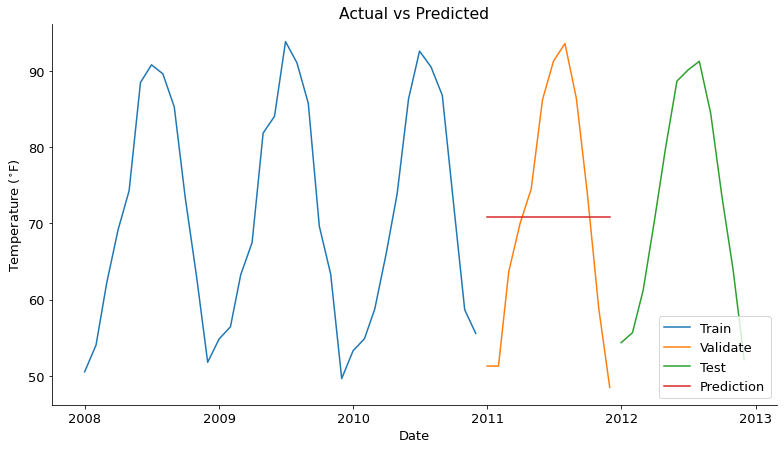

In [37]:
# use a for loop to make forecasts for 1-12 month moving averages
periods = range(1, 13)

for p in periods:
    temp = train.avg_temp.rolling(p).mean().iloc[-1]
    yhat_df = make_predictions()
    model_type = str(p) + 'M Moving Average'
    print(model_type)
    plot_act_vs_pred(target)
    eval_df = append_eval_df(model_type = model_type,
                             target_var = target)

---
### Holt's Linear Trend

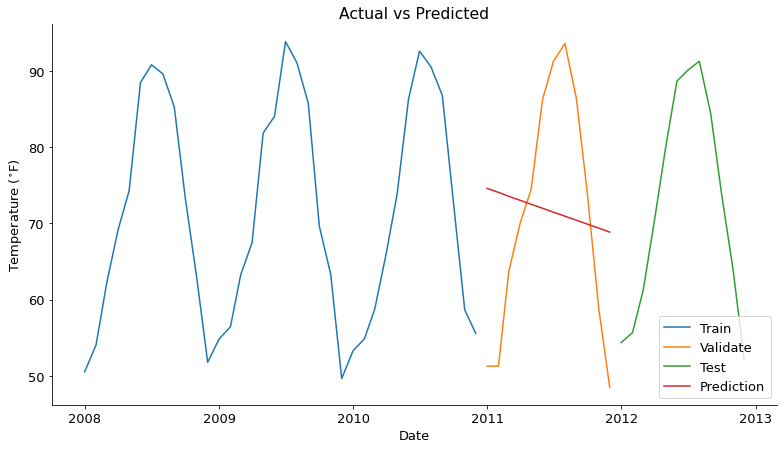

In [38]:
model = Holt(train[target], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df[target] = yhat_items

plot_act_vs_pred(target)

eval_df = append_eval_df(model_type='Holts', target_var=target)

---
### Forecast Based on Previous Cycle

---
#### Train 2008 - 2010
- When finding average yoy change for each month, we will use the average from this larger training set

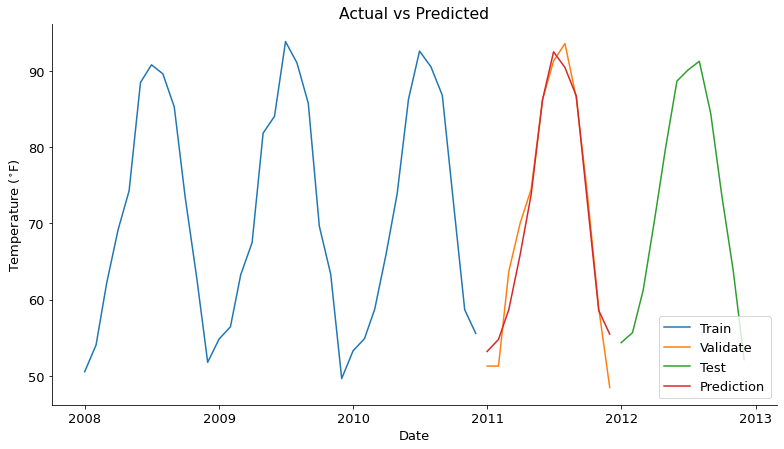

In [39]:
yhat_df = train['2010'] + train.diff(12).mean()

yhat_df.index = validate.index

plot_act_vs_pred(target_var=target)

eval_df = append_eval_df(model_type='Previous Year 8910', target_var=target)

---
#### Train 2009 - 2010
- When finding average yoy change for each month, we will use the average from this larger training set

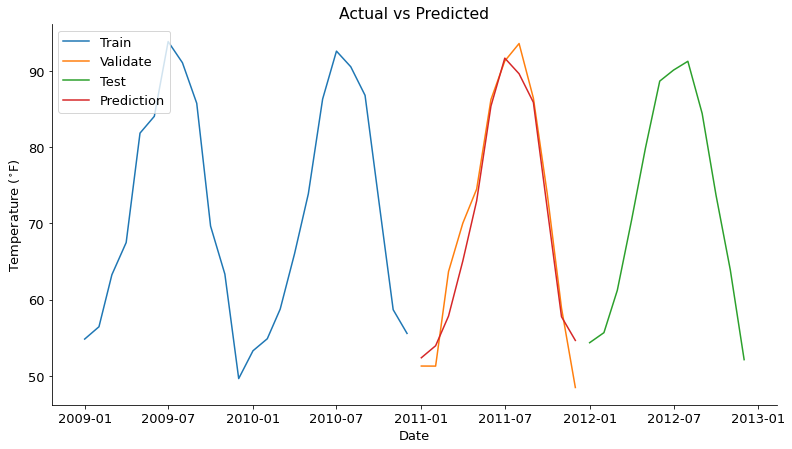

In [40]:
train = df['2009' : '2010']
validate = df['2011']
test = df['2012']

yhat_df = train['2010'] + train.diff(12).mean()

yhat_df.index = validate.index

plot_act_vs_pred(target_var=target)

eval_df = append_eval_df(model_type='Previous Year 910', target_var=target)

---
### Conclusion 

Which model did best?

In [41]:
eval_df.sort_values(by='rmse').head().style.highlight_min(color='red')

,model_type,target_var,rmse
15,Previous Year 8910,avg_temp,3.170000
16,Previous Year 910,avg_temp,3.290000
13,12M Moving Average,avg_temp,15.560000
1,Simple Average,avg_temp,15.570000
12,11M Moving Average,avg_temp,15.650000


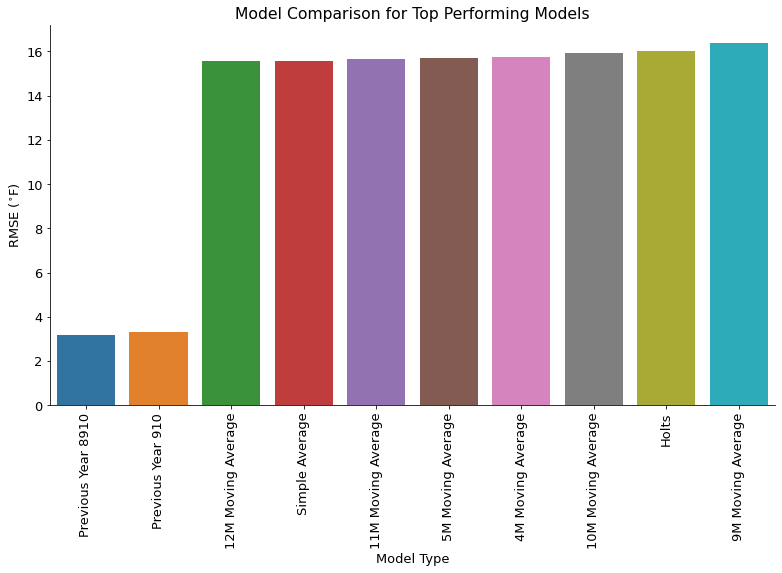

In [42]:
x = eval_df.sort_values(by='rmse').head(10)['model_type']
y = eval_df.sort_values(by='rmse').head(10)['rmse']
sns.barplot(x, y)
plt.title('Model Comparison for Top Performing Models')
plt.ylabel('RMSE ($^{\circ}$F)')
plt.xlabel('Model Type')
plt.xticks(rotation=90)
plt.show()

**The previous year model with the training set of 2008, 2009, and 2010 performed best on validate and will therefore be evaluated on test split.**

---
### Predict on Test 

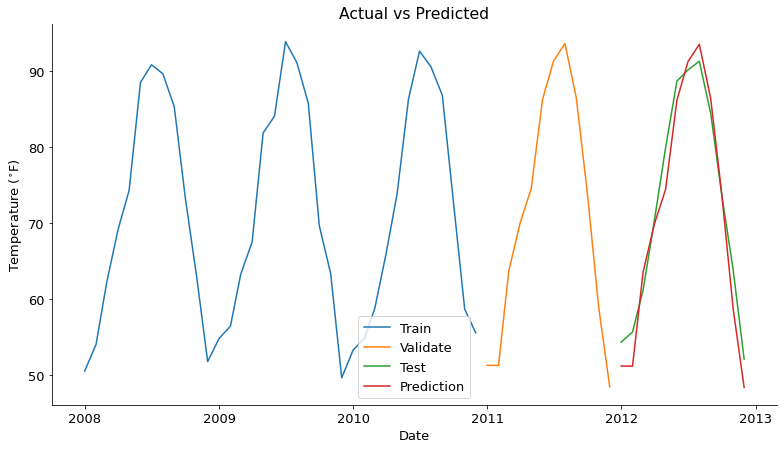

In [43]:
train = df[:'2010']
validate = df['2011']
test = df['2012']

yhat_df = validate + train.diff(12).mean()

yhat_df.index = test.index

plot_act_vs_pred(target_var=target)

eval_df = append_eval_df(model_type='Previous Year Test', target_var=target)

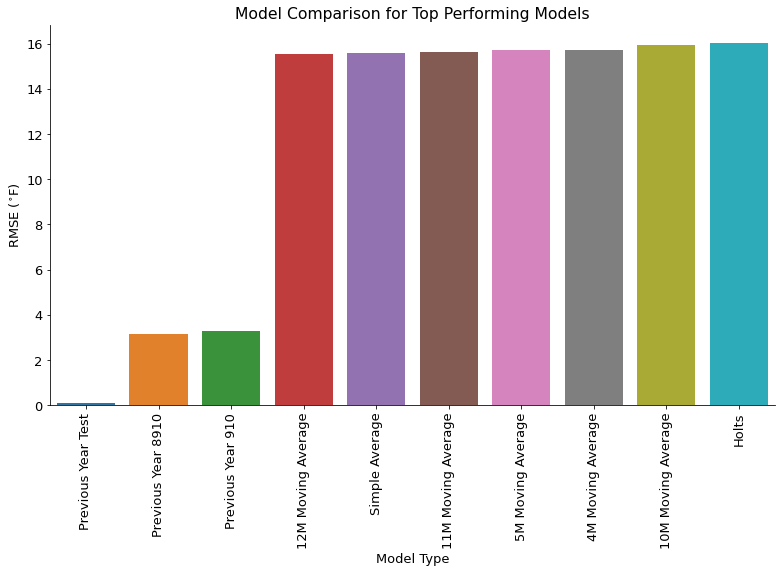

In [44]:
x = eval_df.sort_values(by='rmse').head(10)['model_type']
y = eval_df.sort_values(by='rmse').head(10)['rmse']
sns.barplot(x, y)
plt.title('Model Comparison for Top Performing Models')
plt.ylabel('RMSE ($^{\circ}$F)')
plt.xlabel('Model Type')
plt.xticks(rotation=90)
plt.show()

In [45]:
rmse_test = evaluate(target)

r2 = explained_variance_score(test.avg_temp, yhat_df.avg_temp) 

r2_perc = r2 * 100

print(f'RMSE for best-performing model on test split is {rmse_test} F.\n\nThis forecasting method explains {r2_perc:.2f}% of the variation in temperature based on the date.')

RMSE for best-performing model on test split is 0.09 F.

This forecasting method explains 95.86% of the variation in temperature based on the date.


---
### Forecast into Future
- This is assuming that we have the test data and are now wanting to project a year into the future using same training set from above
- We won't have any way to evaluate this forecast since we have no actual values

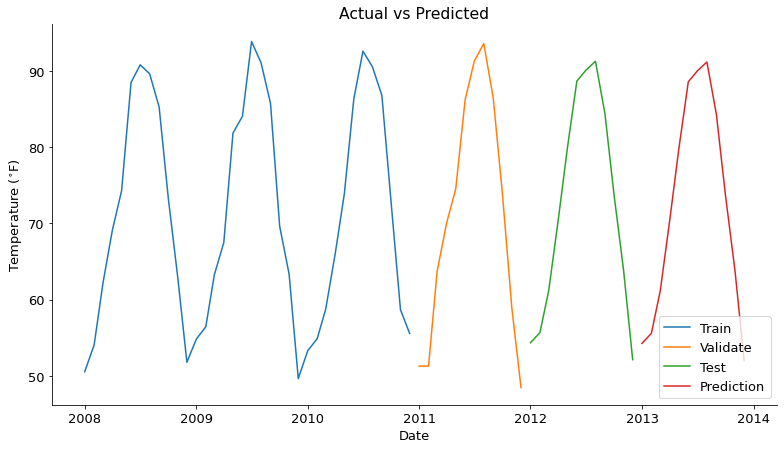

In [46]:
yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

plot_act_vs_pred(target_var=target)